## Import required packages

In [21]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, load_from_disk, load_dataset_builder, get_dataset_split_names, ClassLabel,Dataset,DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

## Login to Huggingface Hub 
To push the trained model to your Hugging Face Hub

In [2]:
from huggingface_hub import notebook_login
notebook_login()

## Load and Explore dataset

In [3]:
dataset_name = "emotion"
dataset = load_dataset(dataset_name)
num_labels = 6
labels = dataset["train"].features["label"].names

C:\Users\easyb\Anaconda3\envs\transformer\lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Transform dataset to dataframe

In [5]:
dataset.set_format(type="pandas")
df = dataset["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


### Convert label

In [6]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### EDA: Label distribution

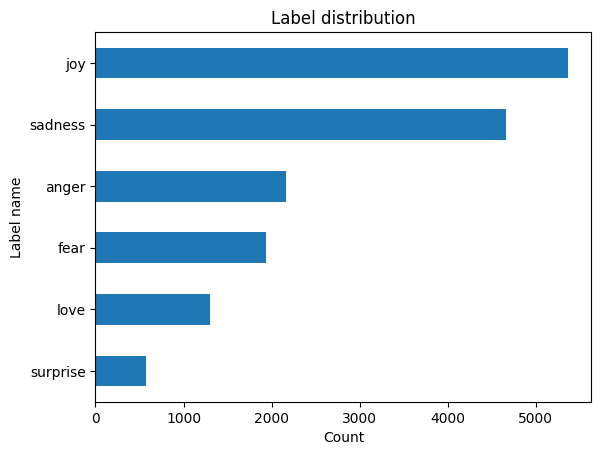

In [7]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Label distribution")
plt.ylabel("Label name")
plt.xlabel("Count")
plt.show()

### EDA: Sweet length per label

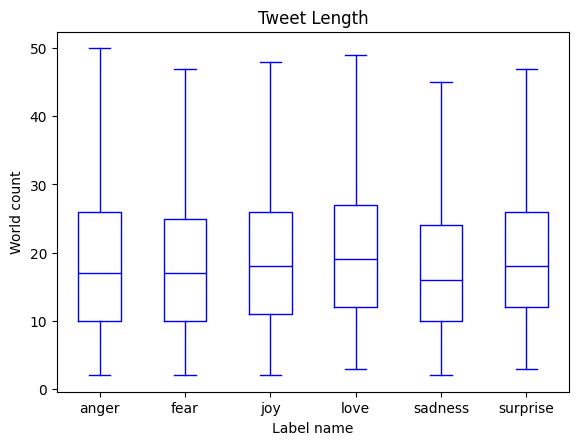

In [8]:
df["Tweet Length"] = df["text"].str.split().apply(len)
df.boxplot("Tweet Length", by="label_name", grid=False, showfliers=False,
           color="blue")
plt.suptitle("")
plt.xlabel("Label name")
plt.ylabel("World count")
plt.show()

# Create balanced dataset from the 'emotion' dataset

In [12]:
# get dataframe format of the dataset
df_train = dataset["train"][:]
df_val = dataset["validation"][:]
df_test = dataset["test"][:]

In [15]:
# combined dataframe
df_combined = pd.concat([df_train, df_val, df_test])
df_combined.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [16]:
# get df_combined shape
df_combined.shape

(20000, 2)

In [17]:
# create label_name feature for df_combined
df_combined["label_name"] = df_combined["label"].apply(label_int2str)
df_combined.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


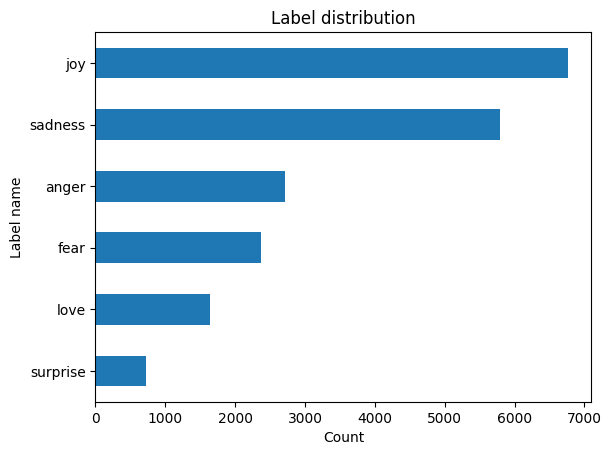

In [18]:
# get label distribution for the df_combined
df_combined["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Label distribution")
plt.ylabel("Label name")
plt.xlabel("Count")
plt.show()

In [20]:
# get label counts
df_combined["label_name"].value_counts(ascending=True)

label_name
surprise     719
love        1641
fear        2373
anger       2709
sadness     5797
joy         6761
Name: count, dtype: int64

## Downsampling

In [26]:
# Separate majority and minority classes
df_fear = df_combined[df_combined.label_name=='fear']
df_anger = df_combined[df_combined.label_name=='anger']
df_sadness = df_combined[df_combined.label_name=='sadness']
df_joy = df_combined[df_combined.label_name=='joy']

In [27]:
len(df_anger)

2709

In [28]:
# Downsample majority classes
df_anger_downsampled = resample(df_anger, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_fear),     # to match minority class
                                 random_state=123) # reproducible results

df_sadness_downsampled = resample(df_sadness, 
                                 replace=False,    
                                 n_samples=len(df_fear),     
                                 random_state=123)

df_joy_downsampled = resample(df_joy, 
                                 replace=False,    
                                 n_samples=len(df_fear),     
                                 random_state=123)

In [29]:
# Combine minority class with downsampled majority classes
df_downsampled = pd.concat([df_fear, df_anger_downsampled, df_sadness_downsampled, df_joy_downsampled])

# Display new class counts
print(df_downsampled.label.value_counts())

label
4    2373
3    2373
0    2373
1    2373
Name: count, dtype: int64


In [31]:
df_downsampled.head()

,text,label,label_name
7,i feel as confused about life as a teenager or...,4,fear
19,i now feel compromised and skeptical of the va...,4,fear
21,i am feeling completely overwhelmed i have two...,4,fear
31,i remember feeling acutely distressed for a fe...,4,fear
53,i was stymied a little bit as i wrote feeling ...,4,fear


In [36]:
# Group by 'label' and 'label_name' and count the number of occurrences
label_group = df_downsampled.groupby(['label', 'label_name']).size()

# Print the mapping
print(label_group)

label  label_name
0      sadness       2373
1      joy           2373
3      anger         2373
4      fear          2373
dtype: int64


In [37]:
# I want to crect the order of the label as 0,1,2,3
# Define a dictionary to map current labels to new labels
label_mapping = {0: 0, 1: 1, 3: 2, 4: 3}

# Use the replace function to apply the mapping
df_downsampled['label'] = df_downsampled['label'].replace(label_mapping)

In [39]:
# Group by 'label' and 'label_name' and count the number of occurrences
label_group = df_downsampled.groupby(['label', 'label_name']).size()

# Print the mapping
print(label_group)

label  label_name
0      sadness       2373
1      joy           2373
2      anger         2373
3      fear          2373
dtype: int64


## Split df_downsampled to train, validation and test subsets

In [40]:
# First split to separate out the training set
df_train, df_temp = train_test_split(df_downsampled, test_size=0.3, random_state=42, stratify=df_downsampled['label_name'])

# Second split to separate out the validation and test sets
df_validation, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label_name'])

## Convert train, validation, test datasets as Dataset object

In [41]:
train_ds = Dataset.from_dict(
    {
        'text': list(df_train['text']),
        'label': list(df_train['label'])
    }
)

test_ds = Dataset.from_dict(
    {
        'text': list(df_test['text']),
        'label': list(df_test['label'])
    }
)

validation_ds = Dataset.from_dict(
    {
        'text': list(df_validation['text']),
        'label': list(df_validation['label'])
    }
)

## Create ClassLabel for Dataset object

In [42]:
# create ClassLabel
labels = ['sadness', 'joy', 'anger', 'fear']
ClassLabels = ClassLabel(num_classes=len(labels), names=labels)

In [43]:
ClassLabels

ClassLabel(names=['sadness', 'joy', 'anger', 'fear'], id=None)

In [44]:
# Casting label column to ClassLabel Object
train_ds = train_ds.cast_column('label', ClassLabels)
validation_ds = validation_ds.cast_column('label', ClassLabels)
test_ds = test_ds.cast_column('label', ClassLabels)

Casting the dataset:   0%|          | 0/6644 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1424 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1424 [00:00<?, ? examples/s]

## Create new dataset as Dataset object

In [45]:
# create new dataset object with DatasetDict class
balanced_emotions_dataset = DatasetDict({
    "train": train_ds, 
    "validation": validation_ds,
    "test": test_ds
})

In [46]:
balanced_emotions_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6644
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1424
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1424
    })
})

In [47]:
balanced_emotions_dataset['train'].features['label']

ClassLabel(names=['sadness', 'joy', 'anger', 'fear'], id=None)

## Check balanced dataset distribution

In [52]:
balanced_emotions_dataset.set_format(type="pandas")
df_balanced = balanced_emotions_dataset["train"][:]

In [53]:
def balanced_label_int2str(row):
    return balanced_emotions_dataset["train"].features["label"].int2str(row)

df_balanced["label_name"] = df_balanced["label"].apply(balanced_label_int2str)
df_balanced.head()

,text,label,label_name
0,i see momo feel shy momo hmmm gt me heyy momo,3,fear
1,ive been feeling really shitty lately,0,sadness
2,i feel messy and out there,0,sadness
3,i just need to find ways to feel pretty,1,joy
4,i dont know why but every time i feel like i a...,0,sadness


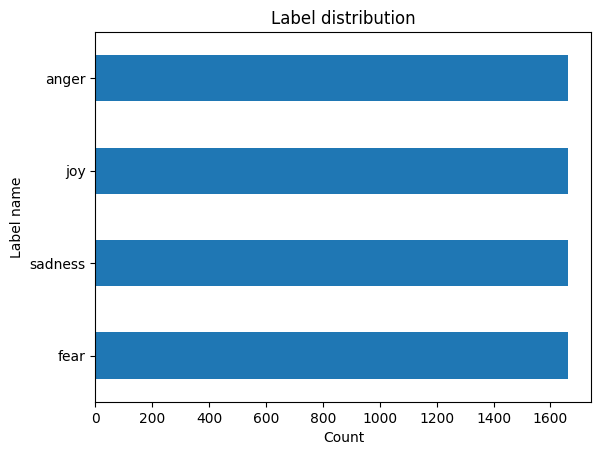

In [54]:
df_balanced["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Label distribution")
plt.ylabel("Label name")
plt.xlabel("Count")
plt.show()

In [55]:
df_balanced["label_name"].value_counts(ascending=True)

label_name
fear       1661
sadness    1661
joy        1661
anger      1661
Name: count, dtype: int64

## Push dataset to hub

In [56]:
balanced_emotions_dataset.push_to_hub("tanquangduong/emotion-balanced")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/tanquangduong/emotion-balanced/commit/ee3e4d7269b97ce2a3808a1e91b5774305aaac26', commit_message='Upload dataset', commit_description='', oid='ee3e4d7269b97ce2a3808a1e91b5774305aaac26', pr_url=None, pr_revision=None, pr_num=None)